<a href="https://colab.research.google.com/github/melihkurtaran/MachineLearning/blob/main/InstanceBasedLearning/InstancebasedLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Instance-based Learning Project**

In [32]:
!pip install cvxpy # download cvxpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [70]:
#Import Libraries
import numpy as np
import pandas as pd
from sklearn.svm import SVC
import cvxpy as cp
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [34]:
#Connect to GitHub for faster access
!git clone https://github.com/melihkurtaran/MachineLearning.git

fatal: destination path 'MachineLearning' already exists and is not an empty directory.


My group number is 9

In [35]:
#Reading the files

#for task 1
ds1 = pd.read_csv('MachineLearning/InstanceBasedLearning/ds091.txt', sep=" ", header=None, index_col=False, skiprows=1)

#for task 2
ds2 = pd.read_csv('MachineLearning/InstanceBasedLearning/ds092.txt', sep=" ", header=None, index_col=False, skiprows=1)

#for task 3
ds3tr = pd.read_csv('MachineLearning/InstanceBasedLearning/ds093tr.txt', sep=" ", header=None, index_col=False, skiprows=1)
ds3te = pd.read_csv('MachineLearning/InstanceBasedLearning/ds093te.txt', sep=" ", header=None, index_col=False, skiprows=1)

# **T1**

In [ ]:
ds1.loc[ds1[2] == 0, 2] = -1

In [45]:
# Load the training data and labels
X = ds1[[0,1]].values
y = ds1[2].values

In [49]:
# Class 0 are negatives and Class 1 are positives
class_0 = ds1.loc[ds1[2] == -1]
class_1 = ds1.loc[ds1[2] == 1]

class_0

,0,1,2
0,-2.131739,0.675048,-1.0
1,-5.656211,-0.085275,-1.0
2,1.350096,4.263477,-1.0
3,-3.567110,2.067782,-1.0
4,-0.781642,4.938526,-1.0
5,-4.938526,-0.781642,-1.0
6,-2.153058,2.089101,-1.0
7,-3.545792,0.653729,-1.0


In [50]:
class_0 = class_0.to_numpy()
class_1 = class_1.to_numpy()

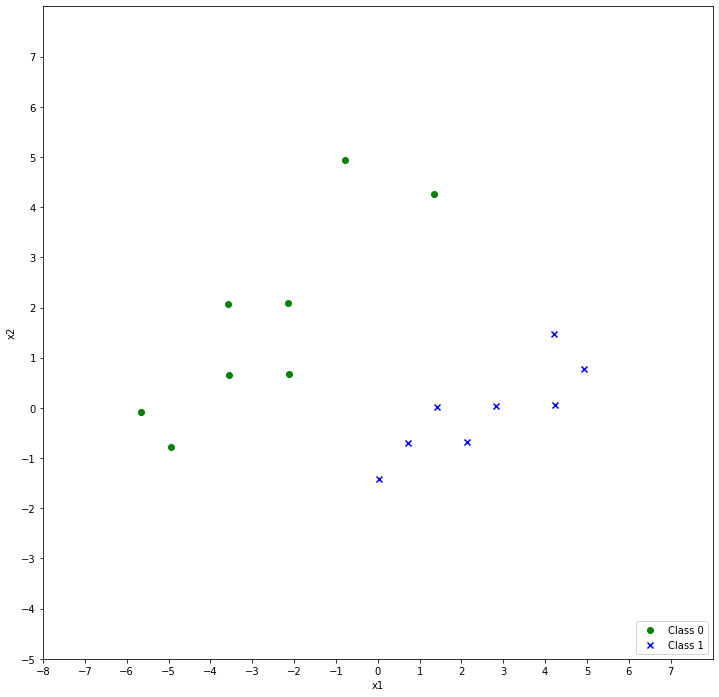

In [51]:
# Plot
fig = plt.figure(figsize=(12, 12))

# Scatter plot for class 0
plt.scatter(class_0[:, 0], class_0[:, 1], 
            marker='o', color='green', 
            label='Class 0')

# Scatter plot for class 1
plt.scatter(class_1[:, 0], class_1[:, 1], 
            marker='x', color='blue', 
            label='Class 1')

# Set plot limits
plt.xlim(-8, 8)
plt.ylim(-5, 8)

# Set axis ticks
plt.xticks(np.arange(-8, 8, step=1))
plt.yticks(np.arange(-5, 8, step=1))

# Set axis labels
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Add labels
plt.xlabel('x1')
plt.ylabel('x2')

# Add legend
plt.legend(loc='lower right')

# Show plot
plt.show()


In [56]:
# N is the number of rows in the data matrix X
N = X.shape[0]

# Reshape y to match the shape of X
y = y.reshape((N,1))

# Create variables for the weights and bias
w = cp.Variable((2,1))
w0 = cp.Variable()

# Define the loss function as the L2 norm of w squared, which is equivalent to the L2 regularization
loss = cp.Minimize(0.5 * cp.square(cp.norm(w)))

# Create an empty list to store the constraints
constr = []

# Iterate through each data point and add a constraint for it
for i in range(N):
  xi, yi = X[i,:], y[i]
  constr += [yi @ (xi @ w + w0) >= 1]

# Create the optimization problem with the loss and constraints
prob = cp.Problem(loss, constr)

# Solve the problem
prob.solve()

# Print the values of the optimized variables
print(w.value, w0.value) # w = [1.0, -1.0], w0 = -1.0

[[ 0.47845723]
 [-0.46424468]] 0.33333333339392063


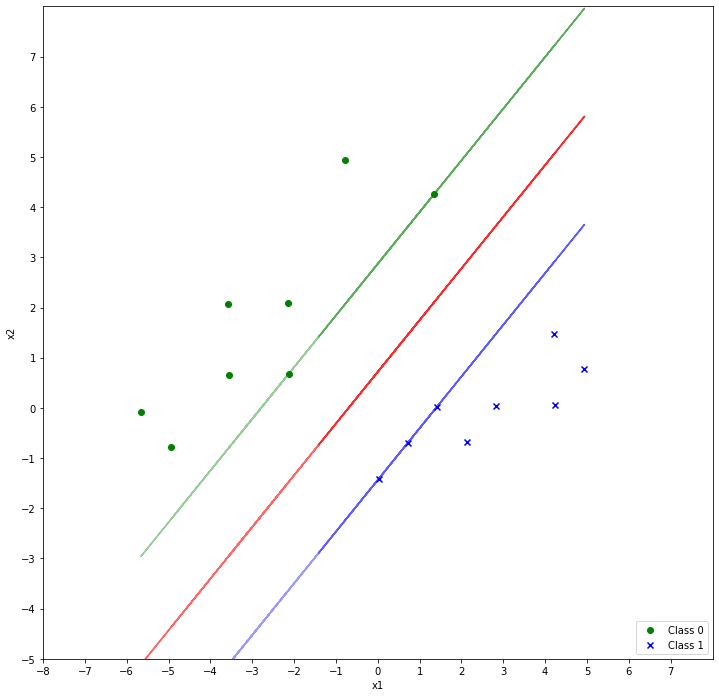

In [67]:
# Plot
fig = plt.figure(figsize=(12, 12))

# Scatter plot for class 0
plt.scatter(class_0[:, 0], class_0[:, 1], 
            marker='o', color='green', 
            label='Class 0')

# Scatter plot for class 1
plt.scatter(class_1[:, 0], class_1[:, 1], 
            marker='x', color='blue', 
            label='Class 1')

# Plot the decision boundary and the margins using the optimized values of w and w0
plt.plot(X, (-w0.value - (w[0].value*X))/w[1].value , 'r', alpha=0.6)

# Plot the positive margin
plt.plot(X, (-w0.value - (w[0].value*X)+1)/w[1].value ,'b', alpha=0.4)

# Plot the negative margin
plt.plot(X, (-w0.value - (w[0].value*X)-1)/w[1].value , 'g', alpha=0.4)

# Set plot limits
plt.xlim(-8, 8)
plt.ylim(-5, 8)

# Set axis ticks
plt.xticks(np.arange(-8, 8, step=1))
plt.yticks(np.arange(-5, 8, step=1))

# Set axis labels
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Add labels
plt.xlabel('x1')
plt.ylabel('x2')

# Add legend
plt.legend(loc='lower right')

# Show plot
plt.show()


# **T2**

# **T3**

In [ ]:
#Train and test
x_train = ds3tr.drop(columns=[2])
y_train = ds3tr[2]

x_test = ds3te.drop(columns=[2])
y_test = ds3te[2]

In [71]:
#Create KNN classifier
knn = KNeighborsClassifier()

#Training the model
knn.fit(x_train, y_train)

#Predict test data set
y_pred = knn.predict(x_test)

#Checking performance our model with classification report
print(classification_report(y_test, y_pred))

#Checking performance our model with ROC Score
roc_auc_score(y_test, y_pred)

              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97        32
         1.0       0.93      1.00      0.97        28

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



0.96875